In [4]:
%pylab notebook

from datacube import Datacube
# from matplotlib import pyplot as plt
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
from datacube_stats.statistics import GeoMedian
cdc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf')
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict

Populating the interactive namespace from numpy and matplotlib


In [3]:
#cdc.list_products()##
cdc.list_measurements()

aliases  \
product                     measurement                                              
dem_3sec_hydrosheds         elevation                                          NaN   
ls5_usgs_sr_scene           blue                                [band_1, sr_band1]   
                            green                               [band_2, sr_band2]   
                            red                                 [band_3, sr_band3]   
                            nir                                 [band_4, sr_band4]   
                            swir1                               [band_5, sr_band5]   
                            swir2                               [band_7, sr_band7]   
                            pixel_qa                                    [pixel_qa]   
ls7_usgs_sr_scene           blue                                [band_1, sr_band1]   
                            green                               [band_2, sr_band2]   
                            red                                 [band_3, sr_band3]   
                            nir                                 [band_4, sr_band4]   
                            swir1                               [band_5, sr_band5]   
                            swir2                               [band_7, sr_band7]   
                            sr_atmos_opacity                            [atmos_op]   
                            pixel_qa                                    [pixel_qa]   
                            radsat_qa                                  [radsat_qa]   
                            sr_cloud_qa                                 [cloud_qa]   
ls8_usgs_sr_scene           coastal_aerosol                     [band_1, sr_band1]   
                            blue                                [band_2, sr_band2]   
                            green                               [band_3, sr_band3]   
                            red                                 [band_4, sr_band4]   
                            nir                                 [band_5, sr_band5]   
                            swir1                               [band_6, sr_band6]   
                            swir2                               [band_7, sr_band7]   
                            pixel_qa                                    [pixel_qa]   
                            sr_aerosol        [sr_aerosol_qa, aerosol_qa, aerosol]   
                            radsat_qa                                  [radsat_qa]   
ls_level2_geomedian_annual  blue                                [band_2, sr_band2]   
                            green                               [band_3, sr_band3]   
                            red                                 [band_4, sr_band4]   
                            nir                                 [band_5, sr_band5]   
                            swir1                               [band_6, sr_band6]   
                            swir2                               [band_7, sr_band7]   
pet_grids_1979_2016         PET                                                NaN   
rainfall_grids_1998_2017    rainfall                                           NaN   
temperature_grids_1979_2016 temperature                                        NaN   

                                                dtype  \
product                     measurement                 
dem_3sec_hydrosheds         elevation           int16   
ls5_usgs_sr_scene           blue                int16   
                            green               int16   
                            red                 int16   
                            nir                 int16   
                            swir1               int16   
                            swir2               int16   
                            pixel_qa           uint16   
ls7_usgs_sr_scene           blue                int16   
                            green               int16   
                            red     

In [19]:
#define temporal range ()
start_of_epoch = '1999-01-01'
end_of_epoch =  '1999-01-02'

query = {'time': (start_of_epoch, end_of_epoch),}

# lat_max = 12.919 #up
# lat_min = 12.855 #down
# lon_min = 101.721 #left
# lon_max = 101.804 #right 

# query['x'] = (lon_min, lon_max)
# query['y'] = (lat_max, lat_min)
# query['crs'] = 'EPSG:4326'

print(query)

#Total number of scenes in Cambodia Cube
# pet_datasets = cdc.find_datasets(product='pet_grids_1979_2016',**query)
rain_datasets = cdc.find_datasets(product='rainfall_grids_1998_2017')#,**query)
#temp_datasets = cdc.find_datasets(product='temperature_grids_1979_2016',**query)
# gm_datasets = cdc.find_datasets(product='ls_level2_geomedian_annual',**query)
# ls8_datasets = cdc.find_datasets(product='ls8_usgs_sr_scene',**query)
# ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene',**query)
# ls5_datasets = cdc.find_datasets(product='ls5_usgs_sr_scene',**query)
# print(len(ls8_datasets))
# print(len(ls7_datasets))
# print(len(ls5_datasets))
# print()

# print (len(ls8_datasets)+len(ls7_datasets)+len(ls5_datasets))
print(len(rain_datasets))

# [x.id for x in ls7_datasets]
# ls5_datasets[0].metadata_doc

{'time': ('1999-01-01', '1999-01-02')}
58440


In [20]:
# test02= cdc.load(product='ls5_usgs_sr_scene',measurements = bands_of_interest,group_by='solar_day', 
#                                        **query)
test01= cdc.load(product='rainfall_grids_1998_2017',**query)
#test02= cdc.load(product='temperature_grids_1979_2016')#,**query)

In [23]:
test01.rainfall.min()

<xarray.DataArray 'rainfall' ()>
array(0.)

In [12]:
test02.temperature#.isel(time=0, latitude=12, longitude=13)

<xarray.DataArray 'temperature' (time: 248, latitude: 13, longitude: 14)>
array([[[   20.408869,    19.577509, ...,    17.551447,    19.869196],
        [   20.563868,    19.858423, ...,    18.183344,    18.695032],
        ...,
        [-9999.      , -9999.      , ..., -9999.      , -9999.      ],
        [-9999.      , -9999.      , ..., -9999.      , -9999.      ]],

       [[   20.408869,    19.577509, ...,    17.551447,    19.869196],
        [   20.563868,    19.858423, ...,    18.183344,    18.695032],
        ...,
        [-9999.      , -9999.      , ..., -9999.      , -9999.      ],
        [-9999.      , -9999.      , ..., -9999.      , -9999.      ]],

       ...,

       [[   20.408869,    19.577509, ...,    17.551447,    19.869196],
        [   20.563868,    19.858423, ...,    18.183344,    18.695032],
        ...,
        [-9999.      , -9999.      , ..., -9999.      , -9999.      ],
        [-9999.      , -9999.      , ..., -9999.      , -9999.      ]],

       [[   20.4

In [37]:
test03=test02
test03.temperature.attrs['nodata'] = 'nan'
test03['temperature'] = test03.temperature.where(test03.temperature<1000)
# test03 = test03.fillna(-9999)

In [58]:
del test03.temperature.attrs['crs']

In [59]:
test03.temperature

<xarray.DataArray 'temperature' (time: 8, latitude: 13, longitude: 14)>
array([[[16.858118, 16.882715, ..., 15.623743, 17.683252],
        [17.025873, 16.860437, ..., 16.790064, 16.469843],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[16.858118, 16.882715, ..., 15.623743, 17.683252],
        [17.025873, 16.860437, ..., 16.790064, 16.469843],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[16.858118, 16.882715, ..., 15.623743, 17.683252],
        [17.025873, 16.860437, ..., 16.790064, 16.469843],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[16.858118, 16.882715, ..., 15.623743, 17.683252],
        [17.025873, 16.860437, ..., 16.790064, 16.469843],
        ...,
        [      nan,       nan, 

In [63]:
test03.time

<xarray.DataArray 'time' (time: 8)>
array(['2016-01-01T00:00:00.000000000', '2016-01-01T03:00:00.000000000',
       '2016-01-01T06:00:00.000000000', '2016-01-01T09:00:00.000000000',
       '2016-01-01T12:00:00.000000000', '2016-01-01T15:00:00.000000000',
       '2016-01-01T18:00:00.000000000', '2016-01-01T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-01T03:00:00 ...
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [24]:
# test03.to_netcdf(path = '/g/data/u46/users/ext547/ewater/input_data/test/output.nc')

In [ ]:
# con.Tair.attrs['nodata'] = 'nan'
con02['Tair'] = con.Tair.where(con.Tair<1000)
# con02 = con02.fillna(-9999)

In [ ]:
test03.temperature

In [ ]:
int(test02.temperature.isel(time = 0, latitude = 12, longitude =13 ).values)

<IPython.core.display.Javascript object>


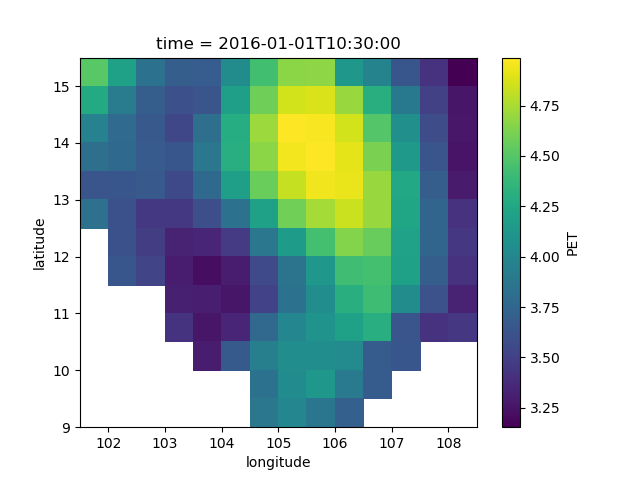

In [10]:
#plt.imshow(test02.temperature.isel(time = 0))
test01.PET.isel(time = 0).plot()

In [ ]:
#define wavelengths/bands of interest
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'pixel_qa',
                     'swir2',
                     ]

start_of_epoch = '2016-01-01'
end_of_epoch =  '2018-01-01'

lat_max = 12.919 #up
lat_min = 12.855 #down
lon_min = 101.721 #left
lon_max = 101.804 #right  1

query = {'time': (start_of_epoch, end_of_epoch),}

query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
# query['crs'] = 'EPSG:4326'

print(query)

In [ ]:
# #Total number of scenes in Cambodia Cube
# ls8_datasets = cdc.find_datasets(product='ls8_usgs_sr_scene',**query)
# ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene',**query)
# ls5_datasets = cdc.find_datasets(product='ls5_usgs_sr_scene',**query)
# print(len(ls8_datasets))
# print(len(ls7_datasets))
# print(len(ls5_datasets))


# print (len(ls8_datasets)+len(ls7_datasets)+len(ls5_datasets))

In [ ]:
# test02 = test02.where(test02.temperature<1000)

In [ ]:
test02

In [ ]:
# plt.imshow(test02.isel(time=0).temperature.values)
# plt.show()

In [ ]:
# test02.elevation.isel(time = 0).plot()

In [ ]:
# plt.imshow(test02.isel(time=0).elevation)

In [ ]:
# rgb = test02.isel(time=0).to_array(dim='color').sel(color=['swir1',
#                                                          'nir', 'green']).transpose('y', 
#                                                                                     'x', 'color')
# fake_saturation = 6000.0
# rgb = rgb.astype('double')
# clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
# max_val = clipped_visible.max(['y', 'x'])
# scaled = (clipped_visible / max_val)

# plt.imshow(scaled)

In [ ]:
#Total number of scenes in Cambodia Cube
ls8_datasets = cdc.find_datasets(product='ls8_usgs_sr_scene',**query)
ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene',**query)
ls5_datasets = cdc.find_datasets(product='ls5_usgs_sr_scene',**query)
print(len(ls8_datasets)+len(ls7_datasets)+len(ls5_datasets))
# ls8_datasets[0].metadata_doc

In [ ]:
# #query number of scenes in certain gm as per year query
# gm_datasets = cdc.find_datasets(product='ls5_usgs_sr_scene',**query)
# len(gm_datasets)

In [ ]:
temp_datasets = cdc.find_datasets(product='temperature_grids_1979_2016')#,**query)

In [ ]:
len(temp_datasets)

In [ ]:
# set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. 
# Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.20


# lat_min = 13.000 #down
# lat_max = 13.500 #up
# lon_min = 103.000 #left
# lon_max = 103.500 #right  


#define temporal range ()
# start_of_epoch = '2014-01-01'
# end_of_epoch =  '2015-01-01'

# #define first time of interest
# start_of_time01 = '2015-01-01'
# end_of_time01 = '2016-05-01'

# #define second time of interest
# start_of_time02 = '2016-05-02'
# end_of_time02 = '2017-12-31'

# start_of_epoch = '2014-01-01'
# end_of_epoch =  '2014-01-02'

#define wavelengths/bands of interest
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'pixel_qa',
                     'swir2',
                     ]

#define Landsat sensors of interest
sensors = ['ls5',]
#        'ls7',] 

#query is created
# query = {'time': (start_of_epoch, end_of_epoch),}
# query['x'] = (lon_min, lon_max)
# query['y'] = (lat_max, lat_min)
# query['crs'] = 'EPSG:4326'

print(query)

In [ ]:
# #define temporal range ()
# start_of_epoch = '2014-01-01'
# end_of_epoch =  '2014-02-01'
# query = {'time': (start_of_epoch, end_of_epoch),}

In [ ]:
test.y[0]

In [ ]:
test02.isel(time=0).pixel_qa

In [ ]:
# plt.imshow(test02.isel(time=0).pixel_qa)

In [ ]:
test= cdc.load(product='ls_level2_geomedian_annual',**query)

In [ ]:
test

In [ ]:
test.isel(time=0).to_array(dim='color').sel(color=['swir1','nir', 'green']).transpose('y', 'x', 'color')

In [ ]:
# rgb = test.isel(time=0).to_array(dim='color').sel(color=['swir1',
#                                                          'nir', 'green']).transpose('y', 
#                                                                                     'x', 'color')
# fake_saturation = 6000.0
# rgb = rgb.astype('double')
# clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
# max_val = clipped_visible.max(['y', 'x'])
# scaled = (clipped_visible / max_val)

# plt.imshow(scaled)

In [ ]:
test.rainfall.max()

In [ ]:
test.latitude.min()

In [ ]:
test= cdc.load(product='ls8_usgs_sr_scene',**query)
# test= test.squeeze()
test

In [ ]:
# three_band_image_subplots(test, ['red','green','blue'], 2, figsize = [30,50])

In [ ]:
# sensor_nbar[0].metadata_doc

In [ ]:
# cdc.load(product='ls7_usgs_sr_scene')

In [ ]:
blah=list(cdc.index.products.search())[1]

In [ ]:
blah.definition

In [ ]:
gm_all_datasets = cdc.find_datasets(product='ls_level2_geomedian_annual')
len(gm_all_datasets)

In [ ]:
ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene',**query)
len(ls7_datasets)

In [ ]:
# list(cdc.index.users.list_users())

In [ ]:
#define temporal range ()
start_of_epoch = '1969-01-01'
end_of_epoch =  '2018-01-01'
query = {'time': (start_of_epoch, end_of_epoch),}
print(query)

In [ ]:
ls8_datasets = cdc.find_datasets(product='ls8_usgs_sr_scene',**query)
ls7_datasets = cdc.find_datasets(product='ls7_usgs_sr_scene',**query)
ls5_datasets = cdc.find_datasets(product='ls5_usgs_sr_scene',**query)
print(len(ls5_datasets)+len(ls7_datasets)+len(ls8_datasets))
# ls8_datasets[0].metadata_doc

In [12]:
del_datasets = cdc.find_datasets(product='pet_grids_1979_2016')#,**query)
len(del_datasets)

0

In [11]:
# # #Remove all/certain files from database. WARNING.
del_eager=[d.id for d in del_datasets]
cdc.index.datasets.archive(del_eager)
del_datasets = cdc.find_datasets(product='pet_grids_1979_2016')

print(len(del_datasets))

0


In [ ]:
# # #Remove all files from database. WARNING.
# ls7_eager=[d.id for d in ls7_datasets]
# cdc.index.datasets.archive(ls7_eager)
# print(len(ls7_datasets))

In [ ]:
# # #Remove all files from database. WARNING.
# ls5_eager=[d.id for d in ls5_datasets]
# cdc.index.datasets.archive(ls5_eager)
# print(len(ls5_datasets))

In [ ]:
# # # Remove specific files from database. WARNING.
# gm_eager=[d.id for d in cdc.index.datasets.search_eager(product='ls_level2_geomedian_annual')]#,**query)]
# cdc.index.datasets.archive(gm_eager)

In [ ]:
# # Remove specific files from database. WARNING.
# gm_eager=[d.id for d in gm_datasets]#cdc.index.datasets.search_eager(product='ls_level2_geomedian_annual',**query)]
# cdc.index.datasets.archive(gm_eager)

In [ ]:
gm_eager

In [ ]:
# # Remove all files from database. WARNING.
# ls7_eager=[d.id for d in cdc.index.datasets.search_eager(product='ls7_usgs_sr_scene')]
# cdc.index.datasets.archive(ls7_eager)

In [ ]:
# # Remove all files from database. WARNING.
# ls8_eager=[d.id for d in cdc.index.datasets.search_eager(product='ls8_usgs_sr_scene')]
# cdc.index.datasets.archive(ls8_eager)

In [ ]:
# cdc_ls7= cdc.load(product='ls7_usgs_sr_scene')
# cdc_ls8 = cdc.load(product='ls8_usgs_sr_scene')

In [ ]:
# print(cdc_ls8.time)
# print(cdc_ls7.time)

In [ ]:
# dc = Datacube(app='dc-show changes in annual mean NDVI values')
# dc.list_products()